In [1]:
# DenseNet(2017),某种程度上，算是 resnet的逻辑扩展
# 如果我们研究泰勒展开，resnet有点像一阶展开： f(x) = x + g(x)
# 如果说resnet的输出是简单相加，那densenet就是连接。dense这个名字由变量间的稠密连接而来
# desenet由两部分组成：稠密块 dense block 和 过渡层 transition layer

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

##### DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”架构。 我们首先实现一下这个架构。

In [3]:
# 有没有发现这里的变化
# 从2015 resnet conv - bn - relu
# 到2017 densenet bn - relu - conv
# 从 post-activation 到 pre-activation 
# 梯度更稳定，更有利于正则化

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

##### 一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。 然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。
##### 我认为可以理解为，每一步的输入，都由前面的所有输出拼接起来

In [4]:
class DenseBlock(nn.Module):
    # 在每个稠密块中，每个卷积层的输出都会作为后续卷积层的输入
    def __init__(self, num_convs, input_channels, num_channels):
        super().__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                i * num_channels + input_channels, num_channels # 注意，这里的每一个conv的输出channel都一样
        ))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim = 1) # X 后面接了 Y
        return X

In [5]:
# 在下面的例子中，我们定义一个有2个输出通道数为10的DenseBlock。 
# 使用通道数为3的输入时，我们会得到通道数为3+2*10=23的输出。 
# 卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [6]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8) # 最后的通道数其实就是 3 + 10 * num_convs
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

##### 由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。
##### 通过1*1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [8]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1), # 减少通道数量
        nn.AvgPool2d(kernel_size=2, stride=2) # 减少特征图尺寸,控制计算量,保持信息平滑Avg
    )

In [9]:
blk = transition_block(23, 10)
Y = blk(Y)
Y.shape

torch.Size([4, 10, 4, 4])

##### 我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层

In [10]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(), # BN让训练更稳定，分布更稳定，学习率可以更大
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [11]:
# 接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。 与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。 
# 这里我们设成4，从而与ResNet-18保持一致。 稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。
# 每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。
# 在这里我们回顾一下，google就是4个并行块，resnet也是4个Residual，每个里面两个卷积块

In [14]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    # 每个稠密块有4个卷积层，一共增加4*32=128个通道
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    # 添加过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [16]:
net = nn.Sequential(
    b1,
    *blks,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

loss 0.148, train acc 0.945, test acc 0.797
1534.0 examples/sec on cuda:0


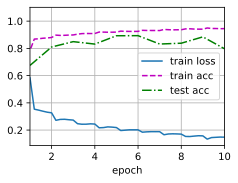

In [17]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# 个人感受
# 1.DenseNet 对高层语义特征依赖少，更像“特征累积器”，对简单语义表现没有resnet好

# 为什么 DenseNet 的过渡层使用平均池化（AvgPool）而不是最大池化（MaxPool）？
# DenseNet 的理念是“保留尽可能多的特征”，而 MaxPool 会损失太多信息

# 为什么 DenseNet 参数比 ResNet 少？
# DenseNet 使用 1× growth + 特征复用，而 ResNet 使用固定通道数

# denseNet 显存/内存占用真的很大吗？
# DenseNet 显存占用高的根本原因是：它要把前面所有层的特征全部保留并拼接 concat 给下一层。

# 有方法减少 DenseNet 的显存消耗吗？需要改框架吗？
# Checkpointing（反向时重新计算）-> 5-10倍减少显存 (前向时不保存这么多通道数据，反向的时候重新算一遍)